In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/')

In [ ]:
import torch
import os
import time
import shutil
from PIL import Image
import numpy as np
import pandas as pd
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from sklearn.metrics import roc_auc_score, roc_curve, auc



In [ ]:
data_dir = '/content/drive/MyDrive/Object-CXR/DATA_DIR'
train_dir = os.path.join(data_dir, 'train')
dev_dir = os.path.join(data_dir, 'dev')

# ─── DATA_DIR
#     ├── train
#     │   ├── #####.jpg
#     │   └── ...
#     ├── dev
#     │   ├── #####.jpg
#     │   └── ...
#     ├── train.csv
#     └── dev.csv

print(train_dir)
print(dev_dir)

/content/drive/MyDrive/Object-CXR/DATA_DIR/train
/content/drive/MyDrive/Object-CXR/DATA_DIR/dev


# Build Dataset

In [ ]:
class ObjectDataset(Dataset):
    """
    Creates a Dataset object of the images and their corresponding labels.
    """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        :param csv_file (string): Path to the csv file with annotations
        :param root_dir (string): Directory with all the images
        :param transform (callable, optional): Optional transform to be applied on a sample
        """
        self.frame = pd.read_csv(csv_file, na_filter=False)
        self.root_dir = root_dir
        self.transform = transform
        # Renaming the 'annotation' column and calling it 'label'
        self.frame = self.frame.rename(columns={"annotation": "label"})
        # Now we change the content of the label column
        # If content is empty i.e. "", then label it 0
        # Otherwise, label it 1
        num_index = range(len(self.frame))
        for idx in num_index:
            label = self.frame.loc[idx, 'label']
            if label == "":
                self.frame.loc[idx, 'label'] = 0
            else:
                self.frame.loc[idx, 'label'] = 1

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.frame.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")  # convert image to RGB

        replaced_label = self.frame.loc[idx, "label"]

        # Applying transforms
        if self.transform:
            for tsfrm in self.transform:
                image = tsfrm(image)

        sample = {"image": image, "label": replaced_label}
        return sample

In [ ]:
# Defining our transforms
img_transforms_tr = [transforms.Compose([transforms.RandomAffine(degrees=(-30, 30),
                                                                 translate=(0.1, 0.1),
                                                                 shear=(-15, 15))]),
                     transforms.Compose([transforms.RandomHorizontalFlip(p=0.5)]),
                     transforms.Compose([transforms.RandomVerticalFlip(p=0.5)]),
                     transforms.Compose([transforms.Resize([800, 800])]),
                     transforms.Compose([transforms.ToTensor()]),
                     transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406],
                                                              [0.229, 0.224, 0.225])])
                     ]

img_transforms_dev = [transforms.Compose([transforms.Resize([800, 800])]),
                      transforms.Compose([transforms.ToTensor()]),
                      transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
                      ]

In [ ]:
# train dataset with transforms
train_dataset = ObjectDataset(csv_file=data_dir + '/train.csv',
                                             root_dir=train_dir,
                                             transform=img_transforms_tr)
# train_dataset.set_format(type='torch', columns=['label'])
dev_dataset = ObjectDataset(csv_file=data_dir + '/dev.csv',
                                           root_dir=dev_dir,
                                           transform=img_transforms_dev)
# dev_dataset.set_format(type='torch', columns=['label'])

# Using DataLoader to load our data
train_dataLoader = DataLoader(train_dataset, batch_size=8, shuffle=True,
                              num_workers=4)
val_dataLoader = DataLoader(dev_dataset, batch_size=8, shuffle=False,
                            num_workers=4)
dataLoaders_dict = {"train": train_dataLoader, "val": val_dataLoader}

# Define Helper Functions

In [ ]:
# --- Helper functions for initialising our inception v3 model ---
def set_parameter_requires_grad(model, feature_extracting):
    """
    This function sets the .requires_grad attribute of the parameters
    in the model to False when we are feature extracting. By default, when
    we load a pretrained model all of the parameters have .requires_grad=True,
    which is fine if we are training from scratch or fine-tuning. However,
    if we are feature extracting and only want to compute gradients for the
    newly initialised layer then we want all of the other parameters to not
    require gradients.

    :param model: The model containing the .requires_grad attributes
    :param feature_extracting: Determines whether the .requires_grad
                               attribute of the parameters are set.
                               If True, param.requires_grad=False,
                               otherwise param.requires_grad=True

    """

    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


def initialise_inception_v3(num_classes, feature_extract, input_size, use_pretrained=True):
    """
    This function initialises an Inception v3 model.

    :param num_classes: The number of classes your Inception v3 model outputs.
    :param feature_extract: Determines whether the .requires_grad attribute of the
                            parameters are set. If True, param.requires_grad=False,
                            otherwise param.requires_grad=True.
    :param input_size: The size of your image as a single value. For example,
                       if image size is (800, 800), input_size=800.
    :param use_pretrained: If True, returns a model pre-trained on ImageNet.

    :return: the inception v3 model, its input size
    """

    model_ft = models.inception_v3(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    # Handle the auxiliary net
    num_ftrs = model_ft.AuxLogits.fc.in_features
    model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = input_size

    return model_ft, input_size


# --- Helper functions to save checkpoints while training ---
def save_checkpoint(state, is_best, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir + '/checkpoint.pt'
    torch.save(state, f_path)
    if is_best:
      best_fpath = best_model_dir + '/best_model.pt'
      shutil.copyfile(f_path, best_fpath)


def load_checkpoint(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath, map_location="cuda:0")
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']


# --- Helper functions to train a model ---
def train_model(model, data_loader, criterion, optimizer, log_path, model_name, num_epochs=10):
    """
    This function trains a model.

    :param model: The model to be trained.
    :param data_loader: A python iterator that will return elements from your dataset
                        batch by batch.
    :param criterion: The loss function.
    :param optimizer: The optimizer used to change the attributes of the model.
    :param log_path: The path to which the performance of your model is logged.
    :param model_name: The name of the model.
    :param num_epochs: The number of epochs.

    :return: None
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    torch.backends.cudnn.benchmark = True

    with open(log_path, 'a') as f:
        best_auc = 0.0
        best_epoch = 0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs - 1}")
            print("-" * 10)

            train_loss = 0.0
            val_loss = 0.0

            train_total = 0
            val_total = 0

            train_correct = 0
            val_correct = 0

            preds_prob = torch.empty(0).to(device)
            gt = torch.empty(0).to(device)

            # Using GPU for model
            model = model.to(device)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                # Iterate over data
                for data in data_loader[phase]:
                    inputs, labels = data.get('image'), data.get('label')
                    inputs, labels = inputs.to(device), labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        if phase == "train":
                            outputs, aux_outputs = model(inputs)
                            outputs_prob = torch.nn.Softmax(dim=1)(outputs)
                            aux_outputs_prob = torch.nn.Softmax(dim=1)(aux_outputs)
                            loss1 = criterion(outputs_prob, labels)
                            loss2 = criterion(aux_outputs_prob, labels)
                            loss = loss1 + 0.4 * loss2
                        else:
                            outputs = model(inputs)
                            outputs_prob = torch.nn.Softmax(dim=1)(outputs)
                            loss = criterion(outputs_prob, labels)

                        scores, predictions = torch.max(outputs_prob, 1)

                        preds_prob = torch.cat((preds_prob, outputs_prob[:, 1]))
                        gt_batch = labels.data.float()
                        gt = torch.cat((gt, labels.data.float()))

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                            # calculate loss and accuracy
                            train_loss += loss.item() * inputs.size(0)
                            train_total += labels.size(0)
                            train_correct += int(torch.sum(predictions == labels))

                        if phase == "val":
                            val_loss += loss.item() * inputs.size(0)
                            scores, predictions = torch.max(outputs.data, 1)
                            val_total += labels.size(0)
                            val_correct += int(torch.sum(predictions == labels))

                # save the model to a checkpoint 
                if phase == "val":
                    checkpoint = {
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                    }
                    checkpoint_dir = '/content/drive/MyDrive/Object-CXR/Inception_v3/Checkpoint'
                    best_model_dir = '/content/drive/MyDrive/Object-CXR/MODEL_DIR'
                    fpr, tpr, _ = roc_curve(gt.tolist(), preds_prob.tolist())
                    epoch_auc = round(auc(fpr, tpr), 3)
                    is_best = True if (epoch_auc > best_auc) else False
                    if epoch_auc > best_auc:
                        best_auc = epoch_auc
                        best_epoch = epoch
                    save_checkpoint(checkpoint, is_best, checkpoint_dir, best_model_dir)

            train_loss = round(train_loss/train_total, 3)
            val_loss = round(val_loss/val_total, 3)
            train_acc = round((float(train_correct) / train_total) * 100, 2)
            val_acc = round((float(val_correct) / val_total) * 100, 2)

            print(f"Epoch: {epoch}, Train loss: {train_loss}, Train accuracy: {train_acc}")
            print(f"\t\tVal loss: {val_loss}, Val accuracy: {val_acc}, AUC: {epoch_auc}")

            # Writing into our log file
            f.write(f"{model_name}, "
                    f"{round(time.time(), 2)}, "
                    f"TL: {train_loss}, "
                    f"TA: {train_acc}, "
                    f"VL: {val_loss}, "
                    f"VA: {val_acc}, "
                    f"AUC: {epoch_auc}\n")

    print(f"Training finished. Best AUC: {best_auc} on epoch {best_epoch}")


def resume_training(model, data_loader, criterion, optimizer,
                    log_path, model_name, start_epoch, best_auc_from_prev,
                    best_epoch_from_prev, num_epochs=10):
    """
    This function resumes the training process from a model.

    :param model: The model to be trained.
    :param data_loader: A python iterator that will return elements from your dataset
                        batch by batch.
    :param criterion: The loss function.
    :param optimizer: The optimizer used to change the attributes of the model.
    :param log_path: The path to which the performance of your model is logged.
    :param model_name: The name of the model.
    :param start_epoch: The starting epoch with which the model is trained in
                        this training loop.
    :param best_auc_from_prev: The best auc obtained from the previous training
                               loop.
    :param best_epoch_from_prev: The epoch from which the best auc was obtained
                                 in the previous training loop.
    :param num_epochs: The number of epochs to train for in this training loop.

    :return: None
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")
    torch.backends.cudnn.benchmark = True

    with open(log_path, 'a') as f:
        best_auc = best_auc_from_prev
        best_epoch = best_epoch_from_prev

        for epoch in range(start_epoch, start_epoch + num_epochs):
            print(f"Epoch {epoch}/{start_epoch + num_epochs - 1}")
            print("-" * 10)

            train_loss = 0.0
            val_loss = 0.0

            train_total = 0
            val_total = 0

            train_correct = 0
            val_correct = 0

            preds_prob = torch.empty(0).to(device)
            gt = torch.empty(0).to(device)

            # Using GPU for model
            model = model.to(device)
            

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                # Iterate over data
                for data in data_loader[phase]:
                    inputs, labels = data.get('image'), data.get('label')
                    inputs, labels = inputs.to(device), labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        if phase == "train":
                            outputs, aux_outputs = model(inputs)
                            outputs_prob = torch.nn.Softmax(dim=1)(outputs)
                            aux_outputs_prob = torch.nn.Softmax(dim=1)(aux_outputs)
                            loss1 = criterion(outputs_prob, labels)
                            loss2 = criterion(aux_outputs_prob, labels)
                            loss = loss1 + 0.4 * loss2
                        else:
                            outputs = model(inputs)
                            outputs_prob = torch.nn.Softmax(dim=1)(outputs)
                            loss = criterion(outputs_prob, labels)

                        scores, predictions = torch.max(outputs_prob, 1)

                        preds_prob = torch.cat((preds_prob, outputs_prob[:, 1]))
                        gt_batch = labels.data.float()
                        gt = torch.cat((gt, labels.data.float()))

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                            # calculate loss and accuracy
                            train_loss += loss.item() * inputs.size(0)
                            train_total += labels.size(0)
                            train_correct += int(torch.sum(predictions == labels))

                        if phase == "val":
                            val_loss += loss.item() * inputs.size(0)
                            scores, predictions = torch.max(outputs.data, 1)
                            val_total += labels.size(0)
                            val_correct += int(torch.sum(predictions == labels))

                # save the model to a checkpoint 
                if phase == "val":
                    checkpoint = {
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                    }
                    checkpoint_dir = '/content/drive/MyDrive/Object-CXR/Inception_v3/Checkpoint'
                    best_model_dir = '/content/drive/MyDrive/Object-CXR/MODEL_DIR'
                    fpr, tpr, _ = roc_curve(gt.tolist(), preds_prob.tolist())
                    epoch_auc = round(auc(fpr, tpr), 3)
                    is_best = True if (epoch_auc > best_auc) else False
                    if epoch_auc > best_auc:
                        best_auc = epoch_auc
                        best_epoch = epoch
                    save_checkpoint(checkpoint, is_best, checkpoint_dir, best_model_dir)

            train_loss = round(train_loss/train_total, 3)
            val_loss = round(val_loss/val_total, 3)
            train_acc = round((float(train_correct) / train_total) * 100, 2)
            val_acc = round((float(val_correct) / val_total) * 100, 2)

            print(f"Epoch: {epoch}, Train loss: {train_loss}, Train accuracy: {train_acc}")
            print(f"\t\tVal loss: {val_loss}, Val accuracy: {val_acc}, AUC: {epoch_auc}")

            # Writing into our log file
            f.write(f"{model_name}, "
                    f"{round(time.time(), 2)}, "
                    f"TL: {train_loss}, "
                    f"TA: {train_acc}, "
                    f"VL: {val_loss}, "
                    f"VA: {val_acc}, "
                    f"AUC: {epoch_auc}\n")

    print(f"Training finished. Best AUC: {best_auc} on epoch {best_epoch}")


# --- Helper functions to print the performance of a model ---
def print_model_performance(file_path):
    """
    This function produces a loss against epoch curve,
    an accuracy against epoch curve,
    and an AUC against epoch curve,
    given a file path in which
    performance data is stored.

    :param file_path: The path in which performance data is stored.

    :return: None
    """

    train_loss_arr = []
    train_acc_arr = []
    val_loss_arr = []
    val_acc_arr = []
    AUC_arr = []

    with open(file_path, 'r') as r_file:
        for i, line in enumerate(r_file):
            model_name, timestamp, train_loss, train_acc, val_loss, val_acc, auc = line.split(', ')  # strings
            # auc ends with a newline which we need to remove
            auc = auc.rstrip("\n")
            train_loss = float(train_loss.split(': ')[1])
            train_acc = float(train_acc.split(': ')[1])
            val_loss = float(val_loss.split(': ')[1])
            val_acc = float(val_acc.split(': ')[1])
            auc = float(auc.split(': ')[1])

            train_loss_arr.append(train_loss)
            train_acc_arr.append(train_acc)
            val_loss_arr.append(val_loss)
            val_acc_arr.append(val_acc)
            AUC_arr.append(auc)

        epoch_arr = np.arange(i+1)

    fig, axs = plt.subplots(1, 3, figsize=(16, 6))
    # loss against epoch graph
    plt.subplot(1, 3, 1)
    plt.plot(epoch_arr, train_loss_arr, label="Train")
    plt.plot(epoch_arr, val_loss_arr, label="Val")
    plt.legend()
    plt.title("Loss vs Epoch", fontsize=18)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xlim(0, epoch_arr[-1] + 1)
    plt.grid(True)

    # accuracy against epoch graph
    plt.subplot(1, 3, 2)
    plt.plot(epoch_arr, train_acc_arr, label="Train")
    plt.plot(epoch_arr, val_acc_arr, label="Val")
    plt.legend()
    plt.title("Accuracy vs Epoch", fontsize=18)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xlim(0, epoch_arr[-1] + 1)
    plt.grid(True)

    # auc against epoch graph
    plt.subplot(1, 3, 3)
    plt.plot(epoch_arr, AUC_arr, label="Val AUC", color="darkorange")
    plt.legend()
    plt.title("AUC vs Epoch", fontsize=18)
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.xlim(0, epoch_arr[-1] + 1)
    plt.grid(True)

    image_save_path = '/content/drive/MyDrive/Object-CXR/Images'
    plt.savefig(f"{image_save_path}/training_performance.png", bbox_inches="tight")
    plt.show()

# Training

In [ ]:
# Creating our Inception_v3 model
feature_extract = False  # when training set to False, when feature extracting set to True
model_ft, input_size = initialise_inception_v3(num_classes=2, feature_extract=feature_extract,
                                                                input_size=800, use_pretrained=True)
print(model_ft)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Gather the parameters to be optimized
params_to_update = model_ft.parameters()
print("Params to learn: ")
feature_extract = False
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad:
            print("\t", name)
total_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print("Number of params to learn:", total_params)
print(params_to_update)

Params to learn: 
	 Conv2d_1a_3x3.conv.weight
	 Conv2d_1a_3x3.bn.weight
	 Conv2d_1a_3x3.bn.bias
	 Conv2d_2a_3x3.conv.weight
	 Conv2d_2a_3x3.bn.weight
	 Conv2d_2a_3x3.bn.bias
	 Conv2d_2b_3x3.conv.weight
	 Conv2d_2b_3x3.bn.weight
	 Conv2d_2b_3x3.bn.bias
	 Conv2d_3b_1x1.conv.weight
	 Conv2d_3b_1x1.bn.weight
	 Conv2d_3b_1x1.bn.bias
	 Conv2d_4a_3x3.conv.weight
	 Conv2d_4a_3x3.bn.weight
	 Conv2d_4a_3x3.bn.bias
	 Mixed_5b.branch1x1.conv.weight
	 Mixed_5b.branch1x1.bn.weight
	 Mixed_5b.branch1x1.bn.bias
	 Mixed_5b.branch5x5_1.conv.weight
	 Mixed_5b.branch5x5_1.bn.weight
	 Mixed_5b.branch5x5_1.bn.bias
	 Mixed_5b.branch5x5_2.conv.weight
	 Mixed_5b.branch5x5_2.bn.weight
	 Mixed_5b.branch5x5_2.bn.bias
	 Mixed_5b.branch3x3dbl_1.conv.weight
	 Mixed_5b.branch3x3dbl_1.bn.weight
	 Mixed_5b.branch3x3dbl_1.bn.bias
	 Mixed_5b.branch3x3dbl_2.conv.weight
	 Mixed_5b.branch3x3dbl_2.bn.weight
	 Mixed_5b.branch3x3dbl_2.bn.bias
	 Mixed_5b.branch3x3dbl_3.conv.weight
	 Mixed_5b.branch3x3dbl_3.bn.weight
	 Mixed_5b.

In [ ]:
# Logging our losses and accuracy to a log file
model_name = f"inception_v3-{int(time.time())}"
log_path = '/content/drive/MyDrive/Object-CXR/Inception_v3/Log/incpetion_v3.txt'

# Defining our optimizer and criterion
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Start our training loop
train_model(model_ft, dataLoaders_dict, criterion, optimizer, log_path, model_name, 5)

Epoch 0/4
----------
Epoch: 0, Train loss: 0.843, Train accuracy: 67.89
		Val loss: 0.486, Val accuracy: 83.0, AUC: 0.76
Epoch 1/4
----------
Epoch: 1, Train loss: 0.754, Train accuracy: 76.83
		Val loss: 0.477, Val accuracy: 83.7, AUC: 0.821
Epoch 2/4
----------
Epoch: 2, Train loss: 0.727, Train accuracy: 79.14
		Val loss: 0.479, Val accuracy: 82.7, AUC: 0.843
Epoch 3/4
----------
Epoch: 3, Train loss: 0.718, Train accuracy: 79.84
		Val loss: 0.473, Val accuracy: 83.8, AUC: 0.853
Epoch 4/4
----------
Epoch: 4, Train loss: 0.709, Train accuracy: 80.51
		Val loss: 0.467, Val accuracy: 84.3, AUC: 0.864
Training finished. Best AUC: 0.864 on epoch 4


In [ ]:
# Continue from where we left off and train for 10 more epochs
# Intialising the inception v3 model and optimizer again
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
feature_extract = False
model, input_size = initialise_inception_v3(num_classes=2, feature_extract=feature_extract,
                                           input_size=800, use_pretrained=True)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load our saved states back to our model using load_checkpoint() function defined above
checkpoint_path = '/content/drive/MyDrive/Object-CXR/Inception_v3/Checkpoint/checkpoint.pt'
model, optimizer, start_epoch = load_checkpoint(checkpoint_path, model, optimizer)

# Continue training, and logging the performance to the same text file
model_name = f"inception_v3-{int(time.time())}"
log_path = '/content/drive/MyDrive/Object-CXR/Inception_v3/Log/incpetion_v3.txt'
criterion = nn.CrossEntropyLoss()
resume_training(model, dataLoaders_dict, criterion, optimizer, log_path,
                model_name, start_epoch + 1, 0.864, 4, 10)

Epoch 5/14
----------
Epoch: 5, Train loss: 0.705, Train accuracy: 81.01
		Val loss: 0.475, Val accuracy: 83.6, AUC: 0.867
Epoch 6/14
----------
Epoch: 6, Train loss: 0.703, Train accuracy: 81.09
		Val loss: 0.469, Val accuracy: 84.0, AUC: 0.871
Epoch 7/14
----------
Epoch: 7, Train loss: 0.688, Train accuracy: 82.47
		Val loss: 0.458, Val accuracy: 85.2, AUC: 0.884
Epoch 8/14
----------
Epoch: 8, Train loss: 0.676, Train accuracy: 82.96
		Val loss: 0.467, Val accuracy: 83.4, AUC: 0.893
Epoch 9/14
----------
Epoch: 9, Train loss: 0.667, Train accuracy: 83.81
		Val loss: 0.467, Val accuracy: 84.0, AUC: 0.899
Epoch 10/14
----------
Epoch: 10, Train loss: 0.663, Train accuracy: 84.34
		Val loss: 0.458, Val accuracy: 84.8, AUC: 0.902
Epoch 11/14
----------
Epoch: 11, Train loss: 0.659, Train accuracy: 84.58
		Val loss: 0.472, Val accuracy: 83.6, AUC: 0.902
Epoch 12/14
----------
Epoch: 12, Train loss: 0.661, Train accuracy: 84.28
		Val loss: 0.464, Val accuracy: 84.4, AUC: 0.901
Epoch 13/1

In [ ]:
# Continue from where we left off and train for 10 more epochs
# Intialising the inception v3 model and optimizer again
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
feature_extract = False
model, input_size = initialise_inception_v3(num_classes=2, feature_extract=feature_extract,
                                           input_size=800, use_pretrained=True)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load our saved states back to our model using load_checkpoint() function defined above
checkpoint_path = '/content/drive/MyDrive/Object-CXR/Inception_v3/Checkpoint/checkpoint.pt'
model, optimizer, start_epoch = load_checkpoint(checkpoint_path, model, optimizer)

# Continue training, and logging the performance to the same text file
model_name = f"inception_v3-{int(time.time())}"
log_path = '/content/drive/MyDrive/Object-CXR/Inception_v3/Log/incpetion_v3.txt'
criterion = nn.CrossEntropyLoss()
resume_training(model, dataLoaders_dict, criterion, optimizer, log_path,
                model_name, start_epoch + 1, 0.912, 14, 10)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Epoch 15/24
----------
Epoch: 15, Train loss: 0.636, Train accuracy: 86.01
		Val loss: 0.446, Val accuracy: 86.4, AUC: 0.919
Epoch 16/24
----------
Epoch: 16, Train loss: 0.648, Train accuracy: 85.05
		Val loss: 0.443, Val accuracy: 86.5, AUC: 0.912
Epoch 17/24
----------
Epoch: 17, Train loss: 0.656, Train accuracy: 84.5
		Val loss: 0.468, Val accuracy: 83.8, AUC: 0.907
Epoch 18/24
----------
Epoch: 18, Train loss: 0.644, Train accuracy: 85.26
		Val loss: 0.464, Val accuracy: 84.5, AUC: 0.917
Epoch 19/24
----------
Epoch: 19, Train loss: 0.639, Train accuracy: 85.6
		Val loss: 0.445, Val accuracy: 86.7, AUC: 0.918
Epoch 20/24
----------
Epoch: 20, Train loss: 0.637, Train accuracy: 85.99
		Val loss: 0.449, Val accuracy: 85.6, AUC: 0.918
Epoch 21/24
----------
Epoch: 21, Train loss: 0.633, Train accuracy: 86.35
		Val loss: 0.446, Val accuracy: 86.3, AUC: 0.922
Epoch 22/24
----------
Epoch: 22, Train loss: 0.627, Train accuracy: 86.71
		Val loss: 0.457, Val accuracy: 85.1, AUC: 0.924
E

In [ ]:
# Continue from where we left off and train for 10 more epochs
# Intialising the inception v3 model and optimizer again
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
feature_extract = False
model, input_size = initialise_inception_v3(num_classes=2, feature_extract=feature_extract,
                                           input_size=800, use_pretrained=True)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load our saved states back to our model using load_checkpoint() function defined above
checkpoint_path = '/content/drive/MyDrive/Object-CXR/Inception_v3/Checkpoint/checkpoint.pt'
model, optimizer, start_epoch = load_checkpoint(checkpoint_path, model, optimizer)

# Continue training, and logging the performance to the same text file
model_name = f"inception_v3-{int(time.time())}"
log_path = '/content/drive/MyDrive/Object-CXR/Inception_v3/Log/inception_v3.txt'
criterion = nn.CrossEntropyLoss()
resume_training(model, dataLoaders_dict, criterion, optimizer, log_path,
                model_name, start_epoch + 1, 0.928, 24, 10)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Epoch 25/34
----------
Epoch: 25, Train loss: 0.618, Train accuracy: 87.31
		Val loss: 0.441, Val accuracy: 86.8, AUC: 0.93
Epoch 26/34
----------
Epoch: 26, Train loss: 0.621, Train accuracy: 87.14
		Val loss: 0.433, Val accuracy: 87.4, AUC: 0.928
Epoch 27/34
----------
Epoch: 27, Train loss: 0.622, Train accuracy: 87.0
		Val loss: 0.439, Val accuracy: 87.3, AUC: 0.93
Epoch 28/34
----------
Epoch: 28, Train loss: 0.61, Train accuracy: 87.74
		Val loss: 0.438, Val accuracy: 87.3, AUC: 0.933
Epoch 29/34
----------
Epoch: 29, Train loss: 0.608, Train accuracy: 88.06
		Val loss: 0.439, Val accuracy: 86.7, AUC: 0.932
Epoch 30/34
----------
Epoch: 30, Train loss: 0.614, Train accuracy: 87.6
		Val loss: 0.444, Val accuracy: 86.2, AUC: 0.931
Epoch 31/34
----------
Epoch: 31, Train loss: 0.615, Train accuracy: 87.4
		Val loss: 0.439, Val accuracy: 87.0, AUC: 0.93
Epoch 32/34
----------
Epoch: 32, Train loss: 0.61, Train accuracy: 87.78
		Val loss: 0.434, Val accuracy: 87.3, AUC: 0.932
Epoch 3

#  Performance Visualisation

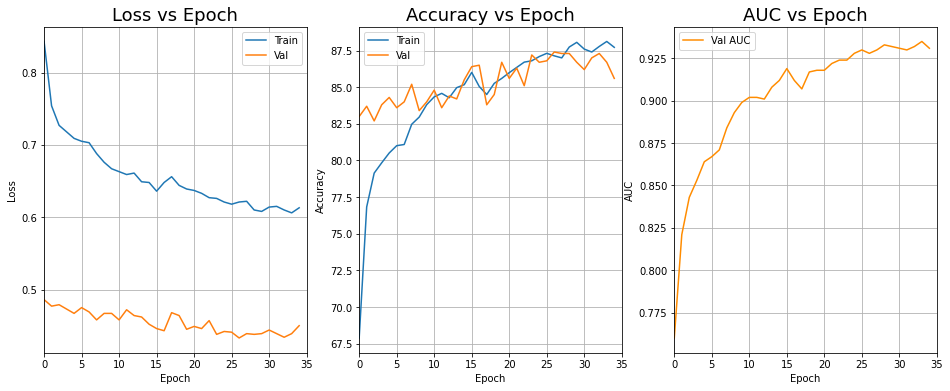

In [ ]:
file_path = '/content/drive/MyDrive/Object-CXR/Inception_v3/Log/inception_v3.txt'
print_model_performance(file_path)